#introduction to machine learning
##pca analysis on MNIST dataset

داخل درس با آنالیز مولفه های اصلی آشنا شده اید ، در این تمرین قصد داریم از ابتدا این روش را روی دیتاست داده شده عملی کنیم و نتیایج این روش را با همدیگر مشاهده کنیم.

In [ ]:
first_name= "Navid"
last_name= "Farmahini Farahani"
student_number= "401210923"
#PCA method is inspired by notes of Adaptive Filters of Professor Babaie-Zadeh

در بخش زیر تمامی کتابخانه هایی که لازم دارید را ایمپورت کنید.

In [ ]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
from tensorflow.nn import softmax_cross_entropy_with_logits as loss_func


### داده شده را لود کنید MNIST در این قسمت دیتا ست  

پیش از این که مولفه های اصلی داده ها را استخراج کنید آن را نرمالایز کنید.
توجه کنید که سمپل های لود شده به صورت 28*28  میباشند و باید آن را به صورت بردار 784 تایی تبدیل کنید

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train_vector=np.reshape(x_train,(x_train.shape[0],x_train.shape[1]*x_train.shape[2]))
num_images=x_train_vector.shape[0]
num_samples=x_train_vector.shape[1]


11490434/11490434 [==============================] - 0s 0us/step


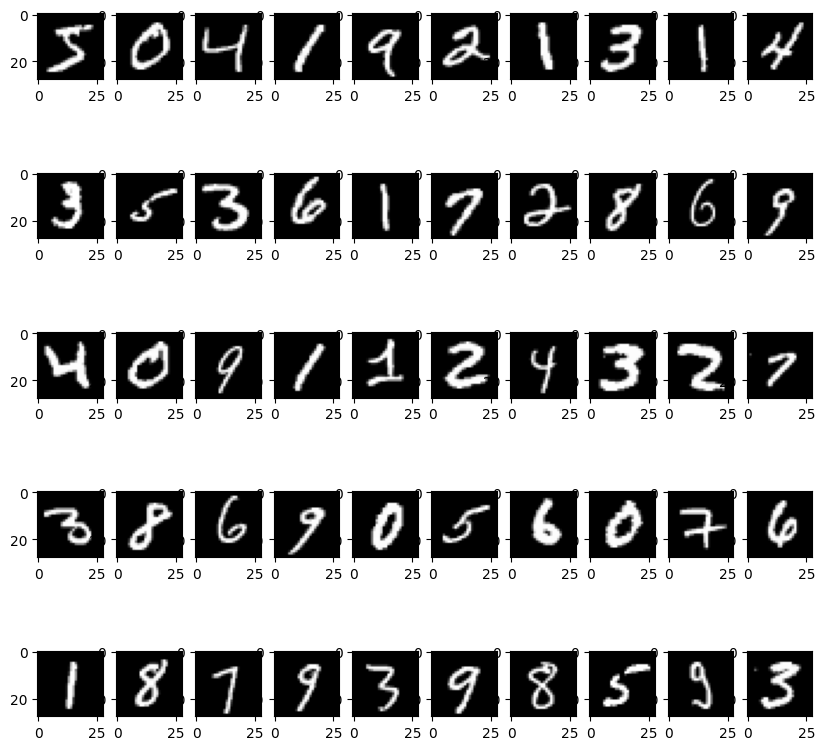

In [ ]:
def show_images(num_images,X):
    plt.figure(figsize=(10,10))
    for i in range(5):
        for j in range(10):
            plt.subplot(5,10,1+10*i+j)
            plt.imshow(x_train[10*i+j],cmap='gray')

show_images(50,X=x_train)

In [ ]:
x_train_vector=x_train_vector.astype('float32')
for k in range(num_images):
    x_train_vector[k,:]=x_train_vector[k,:]/np.max(x_train_vector[k,:])


در این قسمت ابتدا تابع کواریانس داده را بدست آورید و سپس مقادیر ویژه و بردار ویژه های آن را استخراج کنید.

In [ ]:
cov_matrix = np.cov(x_train_vector, rowvar=False)

eigen_values,Q=np.linalg.eig(cov_matrix)


در بخش زیر میخواهیم تعدادی از مولفه های اصلی را استخراج کنیم که بخش قابل قبولی از واریانس داده ها را شامل شده باشند.

In [ ]:
eigen_values2=np.real(eigen_values/sum(eigen_values))


explained_variance = 0.7
s=0
for i in range(num_samples):
    s=s+eigen_values2[i]
    if (s>=explained_variance):
        k=i
        break
print("We need "+str(k+1)+" samples for"+str(explained_variance)+"variance.")

print("Compresion ratio is: "+str(num_samples//(k+1)))


We need 26 samples for0.7variance.
Compresion ratio is: 30


حال در این بخش دیتاهای موجود را روی این مولفه ها تصویر کنید عملیات کاهش بعدد را انجام دهید و سپس ابعاد را به اندازه تصاویر اصلی برگردانید و  تصویر یکی از سمپل ها را برای هر دو حالت قبل از کاهش بعد روی مولفه ها و بعد از آن رسم کنید.

Text(0.5, 1.0, 'compressed image')

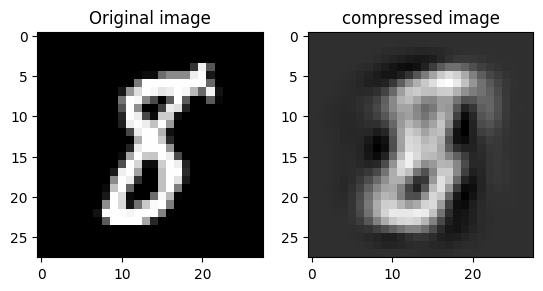

In [ ]:
rotated_x_train_vector=np.dot(Q.T,x_train_vector.T)
rotated_x_train_vector[k:,:]=np.zeros((num_samples-k,num_images))
x_train_vector_compressed=(np.real(np.dot(Q,rotated_x_train_vector))).T

x_train_compressed=np.reshape(x_train_vector_compressed,[num_images,int(np.sqrt(num_samples)),int(np.sqrt(num_samples))])

considered_images=125
plt.subplot(1,2,1)
plt.imshow(x_train[considered_images,:,:],cmap='gray')
plt.title('Original image')
plt.subplot(1,2,2)
plt.imshow(x_train_compressed[considered_images,:,:],cmap='gray')
plt.title('compressed image')

## Perform PCA and Gauge Max Accuracy

حال میخواهیم برای دیتای تصویر شده یک مدل یادگیری بسازیم و دقت مدل را برحسب تعدا مولفه های اصلی بدست بیاوریم .

In [ ]:

from sklearn.decomposition import PCA

def do_pca(n_components,x_train,x_test):
    pca = PCA(n_components=pc)

    x_train_vector=np.reshape(x_train,(x_train.shape[0],x_train.shape[1]*x_train.shape[2]))/255
    x_test_vector=np.reshape(x_test,(x_test.shape[0],x_test.shape[1]*x_test.shape[2]))/255
    x_train_vector=x_train_vector.astype("float32")
    x_test_vector=x_test_vector.astype("float32")

    pca_components_train = pca.fit_transform(x_train_vector[:60000,:])
    pca_components_test = pca.transform(x_test_vector[:10000,:])
    return pca_components_train,pca_components_test


In [ ]:
import tensorflow as tf
import numpy as np
#We used Multi-layer Perceptron Method to train the network.
def initialize(layers):
    #We have to consider weights for each layers. But the number of weights are not equal.
    #So we have to use cell array to define different sizes of weights in different layers.
    #This fact is for biases, too.
    W={}
    b={}
    for i in range(1, len(layers)):
      # Use normal distribution to initialize weights and biases.
      W[i]=tf.Variable(tf.random.normal((layers[i], layers[i-1])))
      b[i]=tf.Variable(tf.random.normal((layers[i], 1)))
    return W,b

def forward_pass(X,W,b,layers):
    #In hidden layers we use nn.relu function and for the last layer, we use no activation functions.

    X=tf.convert_to_tensor(X, dtype=tf.float32)
    for i in range(1,len(layers)):
      Z=tf.matmul(X,tf.transpose(W[i]))+tf.transpose(b[i])
      if i< len(layers)-1:
        X=tf.nn.relu(Z)
      else:
        X=Z
    return X


def update_params(W,b,dW,db,lr,layers):
    #Using gradient descent to update weights and biases with learning rate of lr.
    for i in range(1, len(layers)):
      W[i].assign_sub(lr*dW[i])
      b[i].assign_sub(lr*db[i])

def compute_loss(A,Y):
    #We have a classification problem, so we use softmax_cross_entropy_with_logits
    loss=loss_func(Y,A)
    return tf.reduce_mean(loss)


def predict(X,W,b,layers):
    #To compute validation loss, we need to predict labels by passing forward.
    A=forward_pass(X,W,b,layers)
    A=tf.nn.softmax(A)
    return tf.argmax(A,axis=1)

def ML_model(layers,x_train,y_train,x_test,y_test,epochs,steps_per_epoch, batch_size, lr):
    #We want to calculate accuracy for different epochs, so we define validation_accuray
    validation_accuray=[]

    W,b=initialize(layers)

    for epoch in range(epochs):
      epoch_train_loss=0
      print("Epoch "+str(epoch)+":")
      for i in range(steps_per_epoch):

        x_batch=x_train[i*batch_size:(i+1)*batch_size]
        y_batch=y_train[i*batch_size:(i+1)*batch_size]
        #x_batch and y_batch are a smaller part of x_train and y_train according to batch_size
        #and we convert them to tensor
        x_batch=tf.convert_to_tensor(x_batch,dtype=tf.float32)
        y_batch=tf.convert_to_tensor(y_batch,dtype=tf.float32)

        with tf.GradientTape(persistent=True) as grad:
          A=forward_pass(x_batch,W,b,layers)
          batch_loss=compute_loss(A,y_batch)

        dW={}
        db={}
        for i in range(1,len(layers)):
          dW[i]=grad.gradient(batch_loss,W[i])
          db[i]=grad.gradient(batch_loss,b[i])

        del grad

        update_params(W,b,dW,db,lr,layers)
        epoch_train_loss=epoch_train_loss+batch_loss


      val_preds=predict(x_test,W,b,layers)
      #for this classification problem, if the predicted label and real label are equal, we consider 1
      #otherwise consider 0 and then, we calculate the mean of this array.

      val_accuracy=np.mean(np.argmax(y_test,axis=1)==np.array(val_preds))
      print("For PC"+str(layers[0])+", Accuracy is:"+str(val_accuracy))
      validation_accuray.append(val_accuracy)

    return validation_accuray,W,b

In [ ]:

x_test_vector=np.reshape(x_test,(x_test.shape[0],x_test.shape[1]*x_test.shape[2]))/255

x_train3=x_train_vector[:60000,:]
x_test3=x_test_vector[:10000,:]
y_test3=np.zeros((x_test3.shape[0],10))
for i in range(x_test3.shape[0]):
    y_test3[i,y_test[i]]=1

y_train3=np.zeros((x_train3.shape[0],10))
for i in range(x_train3.shape[0]):
    y_train3[i,y_train[i]]=1

epochs=5
batch_size = 120
lr = 3e-3
steps_per_epoch = int(x_train.shape[0]/batch_size)

acc_list=[]
pc_list=[]
for pc in range(2,101):
    #TODO
    pca_components_train,pca_components_test=do_pca(pc,x_train,x_test)
    layers=[pc,128,128,10]
    acc,W,b=ML_model(layers,
        pca_components_train,y_train3,
        pca_components_test, y_test3,
        epochs, steps_per_epoch,
        batch_size, lr)
    acc_list.append(acc[-1])
    pc_list.append(pc)

Epoch 0:
For PC2, Accuracy is:0.4191
Epoch 1:
For PC2, Accuracy is:0.4093
Epoch 2:
For PC2, Accuracy is:0.4351
Epoch 3:
For PC2, Accuracy is:0.4286
Epoch 4:
For PC2, Accuracy is:0.4339
Epoch 0:
For PC3, Accuracy is:0.427
Epoch 1:
For PC3, Accuracy is:0.4428
Epoch 2:
For PC3, Accuracy is:0.4517
Epoch 3:
For PC3, Accuracy is:0.4439
Epoch 4:
For PC3, Accuracy is:0.4528
Epoch 0:
For PC4, Accuracy is:0.5464
Epoch 1:
For PC4, Accuracy is:0.5483
Epoch 2:
For PC4, Accuracy is:0.5495
Epoch 3:
For PC4, Accuracy is:0.5702
Epoch 4:
For PC4, Accuracy is:0.5812
Epoch 0:
For PC5, Accuracy is:0.6525
Epoch 1:
For PC5, Accuracy is:0.659
Epoch 2:
For PC5, Accuracy is:0.668
Epoch 3:
For PC5, Accuracy is:0.6707
Epoch 4:
For PC5, Accuracy is:0.6689
Epoch 0:
For PC6, Accuracy is:0.7322
Epoch 1:
For PC6, Accuracy is:0.7332
Epoch 2:
For PC6, Accuracy is:0.7411
Epoch 3:
For PC6, Accuracy is:0.7422
Epoch 4:
For PC6, Accuracy is:0.7488
Epoch 0:
For PC7, Accuracy is:0.7786
Epoch 1:
For PC7, Accuracy is:0.7984
Epoc

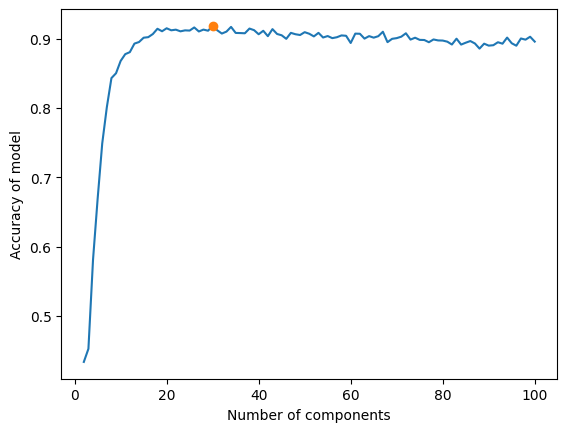

In [ ]:
index=np.where(acc_list==np.max(acc_list))[0][0]
plt.plot(pc_list,acc_list)
plt.xlabel("Number of components")
plt.ylabel("Accuracy of model")
plt.plot(pc_list[index],acc_list[index],'o')

In [ ]:
index=np.where(acc_list==np.max(acc_list))[0][0]
print("The PC that maximize the accuracy is: "+str(int(pc_list[index])))
print("Maximum accuracy is: "+str(np.max(acc_list)))
#The PC that maximize the accuracy is: 30
#Maximum accuracy is: 0.9182

The PC that maximize the accuracy is: 30
Maximum accuracy is: 0.9182
